## Clase 2. Regularizadores, Regresion, optimizacion

In [ ]:
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv("auto-mpg.xls")

In [6]:
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

##  Plots 

<AxesSubplot: xlabel='weight', ylabel='mpg'>

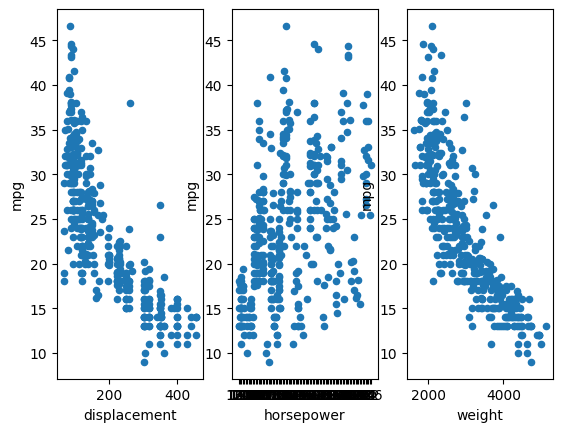

In [10]:
fig, (ax1,ax2,ax3) =plt.subplots(1,3)
df.plot.scatter(x='displacement',y='mpg',ax=ax1)
df.plot.scatter(x='horsepower',y='mpg',ax=ax2)
df.plot.scatter(x='weight',y='mpg',ax=ax3)

In [11]:
X=df[['displacement','weight']]
y=df['mpg']

In [12]:
X_train,X_test,y_train,y_test =   train_test_split(X,y, test_size=0.2,random_state=123)

In [13]:
traindata=pd.concat([X_train,y_train],axis=1)

In [14]:
traindata.head()

,displacement,weight,mpg
232,351.0,4335,16.0
237,98.0,2051,30.5
6,454.0,4354,14.0
220,85.0,1945,33.5
336,140.0,2905,23.6


Triangular Plots

/home/javier/machine_learning_II_bosque_Jan/env3.10/lib/python3.8/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'level'
  cset = contour_func(
/home/javier/machine_learning_II_bosque_Jan/env3.10/lib/python3.8/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'level'
  cset = contour_func(
/home/javier/machine_learning_II_bosque_Jan/env3.10/lib/python3.8/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'level'
  cset = contour_func(


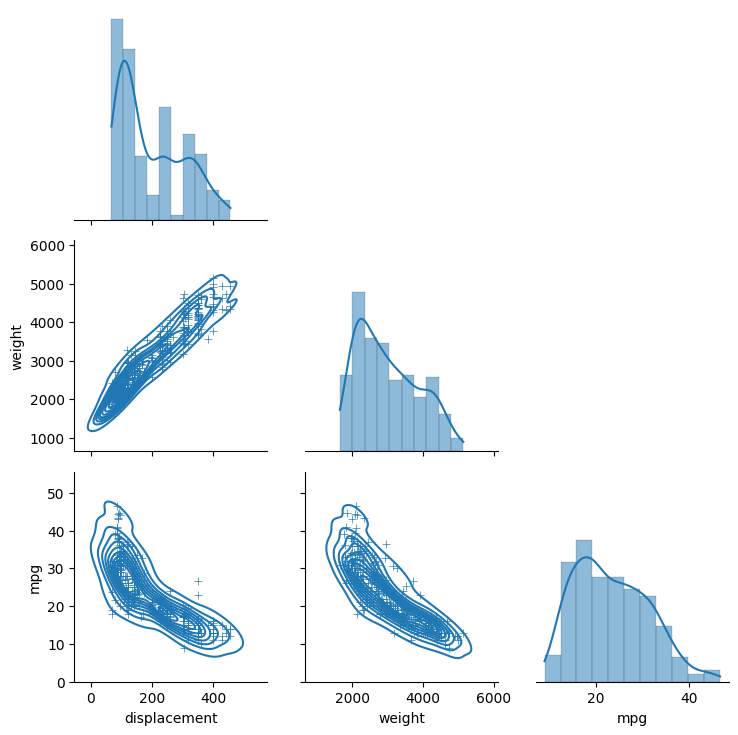

In [16]:
g = sns.PairGrid(traindata,corner=True)
g.map_lower(sns.kdeplot,hue=None, level=5 )
g.map_lower(sns.scatterplot, marker='+')
g.map_diag(sns.histplot, linewidth=0.1, kde=True)

Matriz de correlacion

<AxesSubplot: >

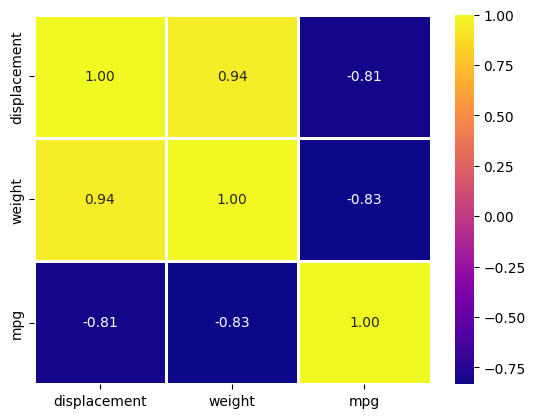

In [17]:
corr_mat=np.corrcoef(traindata,rowvar=False)
corr_df=pd.DataFrame(corr_mat,columns=traindata.columns,index=traindata.columns)
sns.heatmap(corr_df,linewidths=1,cmap='plasma', annot=True,fmt=".2f")

Tabla de correlacion

In [23]:
corr_mat= traindata.corr(method='spearman')
sorted_mat= corr_mat.unstack().sort_values(ascending=False)
print(sorted_mat)

displacement  displacement    1.000000
weight        weight          1.000000
mpg           mpg             1.000000
displacement  weight          0.948833
weight        displacement    0.948833
displacement  mpg            -0.863611
mpg           displacement   -0.863611
weight        mpg            -0.878618
mpg           weight         -0.878618
dtype: float64


#### Variance inflation factor

In [29]:
vif=pd.DataFrame()
vif['VI_factor']=[ variance_inflation_factor(X_train.values, i )  for i in range(X_train.shape[1])]
vif['features']=X_train.columns
vif.round(2)

,VI_factor,features
0,17.1,displacement
1,17.1,weight


preprocesamiento

In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler =StandardScaler()


In [31]:
scaler.fit(X_train)

StandardScaler()

In [32]:
print(scaler.mean_,scaler.var_)

[ 196.28144654 2998.53144654] [ 10997.33037904 733239.62636961]


In [37]:
X_train_n = scaler.transform(X_train)
X_test_n = scaler.transform(X_test)

## Multi regresion con minimos cuadrados
$$E(y_i|x_{i,p}) = \beta_0 + \beta_1x_{i,1} + \beta_2x_{i,2} + \ldots + \beta_px_{i,p}  \space \forall \space i \in \{1, \ldots, n\}$$
$error\sim\sum_{i = 1}^{n} (y_i - \hat{y_i})^2=\|\mathbf{y} - \hat{\mathbf{y}}\|_2^2=|\mathbf{y}-\mathbf{X}\mathbf{\beta} \|_{2}^{2} $

In [39]:
from sklearn.linear_model import LinearRegression

In [40]:
LR = LinearRegression(fit_intercept=True)
LR.fit(X_train_n,y_train)


LinearRegression()

In [42]:
print(LR.coef_,LR.intercept_)

[-1.88955493 -4.76109404] 23.412578616352203


In [48]:
prediccionLR= LR.predict(X_test_n)

In [49]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [50]:
print(r2_score(y_test,prediccionLR),mean_squared_error(y_test,prediccionLR),mean_absolute_error(y_test,prediccionLR))

0.676595018260545 18.862789602942758 3.4980689722029568


# Regularizacion

##  Estimador Ridge 
$$ L(\mathbf{\beta}) =  \|\mathbf{y} - \mathbf{X}\mathbf{\beta}\|_2^2 + \alpha\|\mathbf{\beta}\|_2^2 \: \: \: \text{ con $\alpha \geq 0$} $$

In [64]:
from sklearn.linear_model import Ridge

RLR = Ridge(fit_intercept=True, alpha=0.0001)

RLR.fit(X_train_n,y_train)


Ridge(alpha=0.0001)

In [65]:
print(RLR.coef_,RLR.intercept_)

[-1.88956252 -4.76108537] 23.412578616352203


In [66]:
prediccionRLR=RLR.predict(X_test_n)
print(r2_score(y_test,prediccionRLR),mean_squared_error(y_test,prediccionRLR),mean_absolute_error(y_test,prediccionRLR))

0.6765949804506333 18.86279180822855 3.498069038632822


In [73]:
tuning_params= np.geomspace(1e-6, 5000, 500)
features=list(X_train.columns)
B=[]
for ix in tuning_params:
    RLR= Ridge(alpha=ix)
    B.append(RLR.fit(X_train_n,y_train))
B_int = [s.intercept_ for s in B]
B_coef= [s.coef_ for s in B]

dfRLR= pd.DataFrame(np.column_stack((tuning_params,B_int,B_coef)),columns=['L2','intercepto',*features])


<AxesSubplot: xlabel='Ridge'>

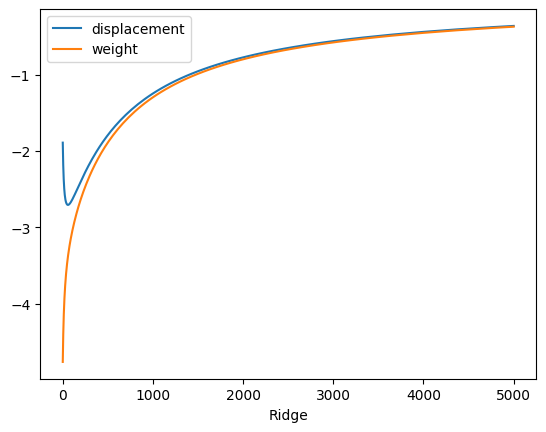

In [76]:
dfRLR.plot(x="L2",y=features,xlabel='Ridge')

## Estimador Lasso(Least Absolute Shrinkage and Selection Operator)
$$ L(\mathbf{\beta}) =  \|\mathbf{y} - \mathbf{X}\mathbf{\beta}\|_2^2 + \lambda\|\mathbf{\beta}\|_1 \: \: \: \text{ con $\lambda \geq 0$} $$

In [78]:
from sklearn.linear_model import Lasso

LLR =Lasso(alpha=0.01)
LLR.fit(X_train_n,y_train)

Lasso(alpha=0.01)

In [79]:
print(LLR.coef_,LLR.intercept_)

[-1.88816378 -4.75240791] 23.412578616352203


In [80]:
prediccionLLR=LLR.predict(X_test_n)
print(r2_score(y_test,prediccionLLR),mean_squared_error(y_test,prediccionLLR),mean_absolute_error(y_test,prediccionLLR))

0.6765377605410854 18.86612919378487 3.4985785053010168


In [81]:
tuning_params= np.geomspace(1e-6, 5000, 500)
features=list(X_train.columns)
B=[]
for ix in tuning_params:
    LLR= Lasso(alpha=ix)
    B.append(LLR.fit(X_train_n,y_train))
B_int = [s.intercept_ for s in B]
B_coef= [s.coef_ for s in B]

dfLLR= pd.DataFrame(np.column_stack((tuning_params,B_int,B_coef)),columns=['L1','intercepto',*features])

<AxesSubplot: xlabel='lasso'>

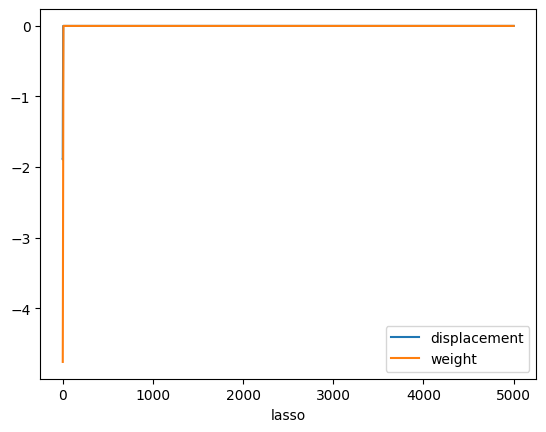

In [82]:
dfLLR.plot(x='L1',y=features,xlabel='lasso')

## Estimador Lastic Net
$$ L(\mathbf{\beta}) =  \|\mathbf{y} - \mathbf{X}\mathbf{\beta}\|_2^2 + \lambda [(1-\alpha)\frac{1}{2} \|\mathbf{\beta}\|_2^2 + \alpha \|\mathbf{\beta}\| ] \: \: \: \text{ con $\lambda \geq 0, \quad 0 \leq \alpha \leq 1$  } $$

In [85]:
from sklearn.linear_model import ElasticNet

ENLR= ElasticNet(alpha=0.01,l1_ratio=0.5)
ENLR.fit(X_train_n,y_train)

ElasticNet(alpha=0.01)

In [86]:
print(ENLR.coef_,ENLR.intercept_)

[-2.00022901 -4.6284265 ] 23.412578616352203


In [87]:
prediccionENLR=ENLR.predict(X_test_n)
print(r2_score(y_test,prediccionENLR),mean_squared_error(y_test,prediccionENLR),mean_absolute_error(y_test,prediccionENLR))

0.6759460023555608 18.900643845010503 3.499358044588573


In [89]:
tuning_params= np.geomspace(1e-6, 5000, 500)
l1_ratio= np.arange(0.01,0.99,0.04)
features=list(X_train.columns)
df1={}
for idx, la in enumerate(l1_ratio):
    B=[]
    for ix in tuning_params:
        ENLLR= ElasticNet(alpha=ix,l1_ratio=la)
        B.append(ENLLR.fit(X_train_n,y_train))
    B_int = [s.intercept_ for s in B]
    B_coef= [s.coef_ for s in B]
    df1[idx]= pd.DataFrame(np.column_stack((tuning_params,B_int,B_coef)),columns=['L1L2','intercepto',*features])










(-0.7, 0.1)

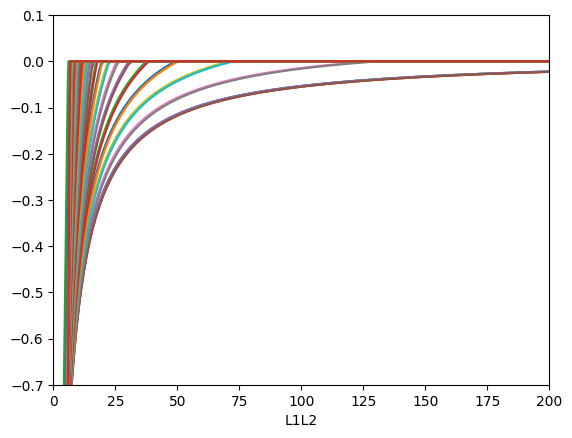

In [93]:
ax= df1[0].plot(x="L1L2",y=features)
df1[0].plot(x="L1L2",y=features,ax=ax)
for i, en in enumerate(l1_ratio):
    df1[i].plot(x="L1L2",y=features,ax=ax,label=[en,en])
plt.legend('',frameon=False)
plt.xlim(0,200)
plt.ylim(-0.7, 0.1)


# Regresion  Polinomial 
$$E(y_i|x_{i,p}) = \beta_0+\beta_1x_{i,1} + \beta_2x_{i,2} \rightarrow E(y_i|x_{i,p}) = \beta_0 + \beta_1x_{i,1} + \beta_2x_{i,2} +\beta_3x_{i,1}^2 + \beta_4x_{i,2}^2 + \beta_5x_{i,2}x_{i,1} $$
#### Interaction only:
$$ E(y_i|x_{i,p}) = \beta_0 + \beta_1x_{i,1} + \beta_2x_{i,2} + \beta_5x_{i,2}x_{i,1} \quad  $$ 

In [95]:
from sklearn.preprocessing import PolynomialFeatures

polyfeat= PolynomialFeatures(degree=2, interaction_only=False)
X_train_n_poly =polyfeat.fit_transform(X_train_n)
X_test_n_poly=polyfeat.transform(X_test_n)

In [98]:
poly =LinearRegression(fit_intercept=True)
poly.fit(X_train_n_poly,y_train)

LinearRegression()

In [99]:
prediccionpoly=poly.predict(X_test_n_poly)

In [100]:
print(poly.coef_,poly.intercept_)

[ 0.         -3.44649657 -4.07944067 -1.00747565  4.13746727 -1.47476049] 21.987211153390465


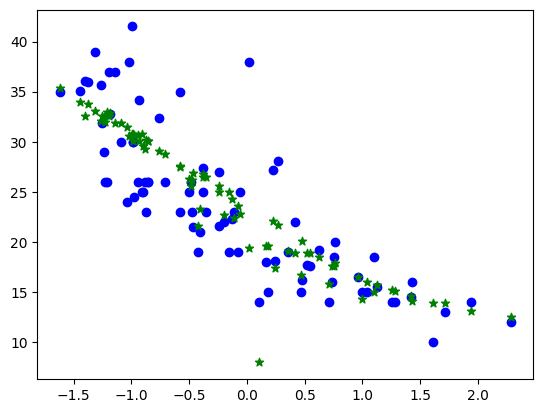

In [104]:
plt.scatter(X_test_n[:,1], y_test, color='blue', marker='o')
plt.scatter(X_test_n[:,1], prediccionpoly, color='green', marker='*')

## Regresor usando SGD

In [106]:
from sklearn.linear_model import SGDRegressor

sgd=SGDRegressor(loss='squared_error', penalty='l2', max_iter=30, alpha=0.1,fit_intercept=True)
sgd.fit(X_train_n,y_train)

SGDRegressor(alpha=0.1, max_iter=30)

In [108]:
prediccionsgd=sgd.predict(X_test_n)
print(r2_score(y_test,prediccionsgd),mean_squared_error(y_test,prediccionsgd),mean_absolute_error(y_test,prediccionsgd))

0.6662987884825189 19.463323382484 3.519677585547737


In [109]:
print(sgd.coef_)

[-2.73364637 -3.59437297]


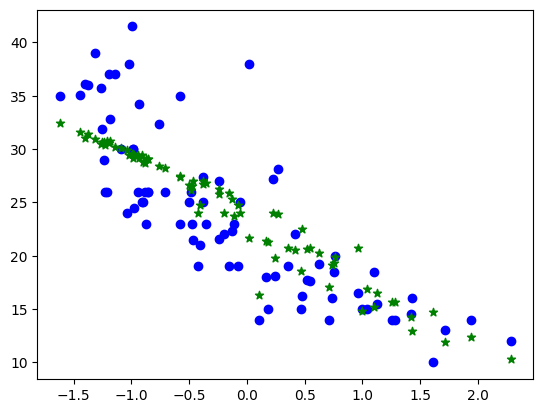

In [110]:
plt.scatter(X_test_n[:,1], y_test, color='blue', marker='o')
plt.scatter(X_test_n[:,1], prediccionsgd, color='green', marker='*')